# Midi2Vec Vector Model Inspection

## Imports

In [1]:
import gensim
import gensim.models.doc2vec
from gensim.models import Doc2Vec

import numpy as np
import pandas as pd

from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import itertools
import random
from random import shuffle

import ipywidgets as widgets

## Load Model to Inspect

In [15]:
path_to_stored_model = "encoders/dm_1-dmmean_1-epochs_8-hs_0-learningrateend_0.2-learningratestart_0.025-mincount_10-negative_15-vectorsize_16-window_4"
model = Doc2Vec.load(path_to_stored_model)

## Dimensionality Reduction via Manifold Learning

Reduce the dimensions to 2 so that the vectors can be graphed in a 2D plane.

In [16]:
data = model[model.wv.vocab]

k = 5 # number of nearest neighbors to consider
d = 2 # dimensionality
data_dim_reduced = manifold.Isomap(k, d, eigen_solver='auto').fit_transform(data)

## Data Preparation

Create data structures for graphing vectors.

In [17]:
instruments = {}
points_to_plot = {}

for word_index, word in enumerate(model.wv.vocab):
    fields = word.split("_")
    if len(fields) > 1:
        instrument = fields[0]
        if instrument == "percussion":
            note = "drum"
        else:
            # Strip octave information from note
            note = fields[1]
            note = ''.join([i for i in note if not i.isdigit()])
    else:
        instrument = "rest"
        note = "rest"
    
    # Create indices for each unique instrument
    if instrument in instruments:
        instrument_index = instruments[instrument]
    else:
        instrument_index = len(instruments)
        instruments[instrument] = instrument_index
    
    # Group points to be plotted by their instrument
    point = data_dim_reduced[word_index]
    coordinates = (point[0], point[1])
    if instrument_index in points_to_plot:
        points_to_plot[instrument_index].append(coordinates)
    else:
        points_to_plot[instrument_index] = [coordinates]

In [27]:
instruments_to_plot = [
    'bass',
    #'brass',
    #'chromatic',
    #'ensemble',
    #'ethnic',
    'guitar',
    #'organ',
    #'percussion',
    #'percussive',
    'piano',
    #'pipe',
    #'reed',
    #'rest',
    #'soundfx',
    'strings',
    #'synthfx',
    'synthlead',
    'synthpad'
]

instrument_ids_to_plot = {instruments[key] for key in instruments.keys() if key in instruments_to_plot}

## Render Plot

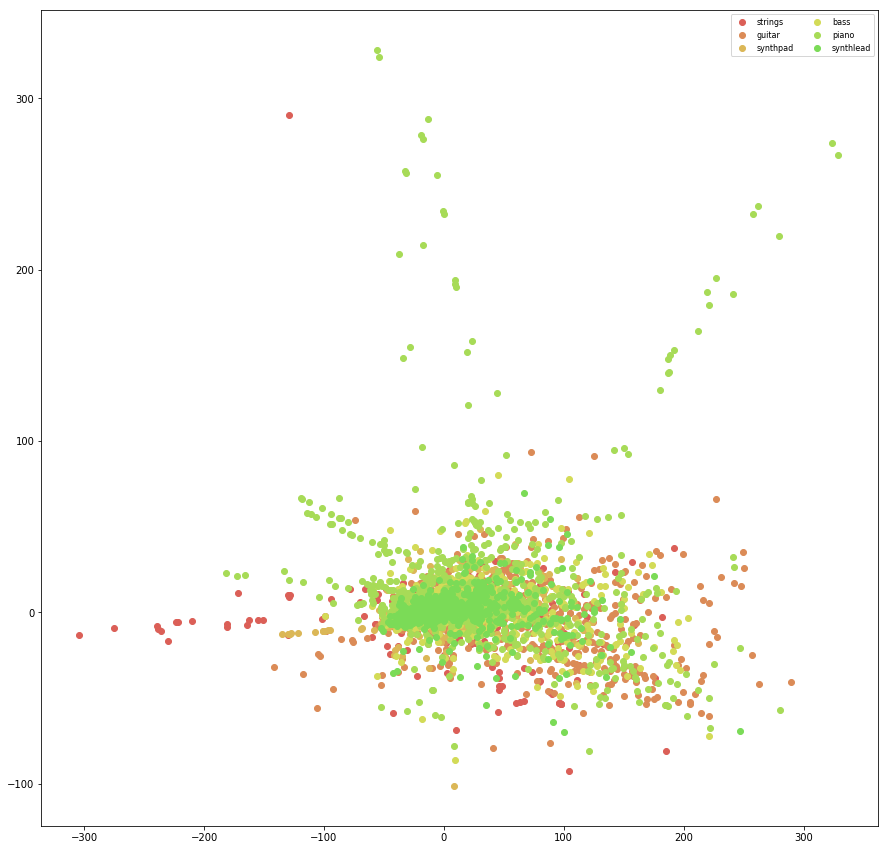

In [30]:
fig = plt.figure()
fig.set_size_inches(15, 15)
ax = fig.add_subplot(1,1,1)

series = []
labels = []
sns.set_palette(sns.color_palette("hls", len(instruments)), len(instruments))
palette = itertools.cycle(sns.color_palette(n_colors=len(instruments)))
for instrument_id in points_to_plot:
    if instrument_id in instrument_ids_to_plot:
        color=next(palette)
        points = points_to_plot[instrument_id]
        x_vals = [i[0] for i in points]
        y_vals = [i[1] for i in points]
        instrument = list(instruments.keys())[list(instruments.values()).index(instrument_id)]
        labels.append(instrument)
        series.append(ax.scatter(x_vals, y_vals, color=color))
        point = random.choice(points)
        #ax.annotate(instrument, (point[0],point[1]))

plt.legend(series,
           labels,
           scatterpoints=1,
           loc='upper right',
           ncol=2,
           fontsize=8)
    
plt.show()

## Create DataFrame of Note-to-Note Similarities

In [20]:
NOTE_NAMES = ["c", "c#", "d", "d#", "e", "f", "f#", "g", "g#", "a", "a#", "b"]

def _get_instrument(word):
    fields = word.split("_")
    if len(fields) > 1:
        instrument = fields[0]
        return instrument
    else:
        return None

def _get_note_and_octave(word):
    fields = word.split("_")
    if len(fields) > 1:
        note_field = fields[1]
        octave = _get_octave(note_field)
        note = ''.join([i for i in note_field if not i.isdigit()])
        return (note, octave)
    else:
        return None
    
def _get_duration(word):
    fields = word.split("_")
    if len(fields) > 1:
        return fields[2]
    else:
        return None
        
def _get_octave(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

# Get words to analyze
note_words = {key: model.wv.vocab[key] for key in model.wv.vocab.keys() if "_" in key and "percussion" not in key}
combinations = list(itertools.combinations(note_words, r=2))
combinations = random.sample(combinations, 10000)

df_rows = []
for word1, word2 in combinations:
    word1_fields = word1.split("_")
    word2_fields = word2.split("_")
    
    # Instruments, Durations
    word1_instrument = _get_instrument(word1)
    word2_instrument = _get_instrument(word2)
    word1_duration = float(_get_duration(word1))
    word2_duration = float(_get_duration(word2))
    note_duration_diff = abs(word1_duration - word2_duration)
    
    # Frequencies
    word1_count = model.wv.vocab[word1].count
    word2_count = model.wv.vocab[word2].count
    
    # Vector similarity
    similarity = model.wv.similarity(word1, word2)
    
    # Octaves / Distances
    word1_note, word1_octave = _get_note_and_octave(word1)
    word2_note, word2_octave = _get_note_and_octave(word2)
    note_distance = abs(NOTE_NAMES.index(word1_note) - NOTE_NAMES.index(word2_note))
    total_distance = note_distance + (abs(word1_octave - word2_octave)*12)
    
    # Log to DF
    row = {"word1": word1, "word2": word2, 
           "word1_instrument": word1_instrument, "word2_instrument": word2_instrument, 
           "word1_note": word1_note, "word2_note": word2_note, 
           "word1_octave": word1_octave, "word2_octave": word2_octave,
           "word1_duration": word1_duration, "word2_duration": word2_duration, 
           "note_duration_diff": note_duration_diff,
           "note_distance": float(note_distance), "total_distance": float(total_distance), 
           "similarity": similarity}
    df_rows.append(row)

df = pd.DataFrame(df_rows)
df["same_instrument"] = df["word1_instrument"] == df["word2_instrument"]
df["same_instrument"] = df["same_instrument"].astype(int)

In [21]:
df.describe()

,note_distance,note_duration_diff,similarity,total_distance,word1_duration,word1_octave,word2_duration,word2_octave,same_instrument
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.027500,3.844925,0.480137,29.179500,2.795100,4.674600,3.737575,4.555400,0.067900
std,2.838582,4.820724,0.295170,19.174604,3.604622,1.575044,4.924927,2.089729,0.251587
min,0.000000,0.000000,-0.946338,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000
25%,2.000000,0.750000,0.315678,15.000000,0.750000,4.000000,0.750000,3.000000,0.000000
50%,4.000000,2.000000,0.523067,26.000000,1.500000,5.000000,1.750000,4.000000,0.000000
75%,6.000000,5.500000,0.697475,41.000000,3.000000,6.000000,4.000000,6.000000,0.000000
max,11.000000,31.750000,0.991039,113.000000,32.000000,10.000000,32.000000,10.000000,1.000000


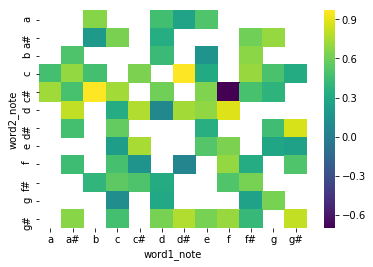

In [22]:
import seaborn as sns

heatmap_x = "word1_note"
heatmap_y = "word2_note"

filtered = df[(df["same_instrument"] == 1) & (df["total_distance"] < 12)]
grouped = filtered.groupby([heatmap_y, heatmap_x], as_index=False).median()
pivoted = grouped.pivot(heatmap_y, heatmap_x, "similarity")
sns.heatmap(pivoted, annot=False, fmt="g", cmap='viridis')

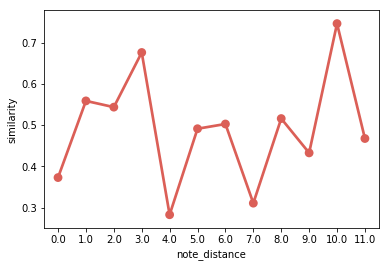

In [23]:
variable = "note_distance"

filtered = df[(df["same_instrument"] == 1) & (df["total_distance"] <= 12)]
grouped = filtered[[variable,'similarity']].groupby([variable], as_index=False).median()
sns.pointplot(x=variable, y='similarity', data=grouped)

In [24]:
most_similar = df.sort_values(by='similarity', ascending=False).head(100)
most_dissimilar = df.sort_values(by='similarity', ascending=True).head(100)

In [25]:
most_similar.describe()

,note_distance,note_duration_diff,similarity,total_distance,word1_duration,word1_octave,word2_duration,word2_octave,same_instrument
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.44000,6.507500,0.961767,35.040000,4.940000,4.540000,5.552500,4.750000,0.130000
std,2.95529,7.999168,0.010220,23.798786,5.993275,2.032166,7.566731,2.491906,0.337998
min,0.00000,0.000000,0.946505,1.000000,0.250000,1.000000,0.250000,0.000000,0.000000
25%,2.00000,0.750000,0.953162,16.750000,1.000000,3.000000,0.750000,3.000000,0.000000
50%,4.00000,2.500000,0.961222,28.500000,1.750000,4.500000,1.750000,4.000000,0.000000
75%,6.00000,11.062500,0.968138,50.500000,8.000000,6.000000,8.000000,7.000000,0.000000
max,11.00000,31.750000,0.991039,98.000000,32.000000,8.000000,32.000000,10.000000,1.000000


In [26]:
most_dissimilar.describe()

,note_distance,note_duration_diff,similarity,total_distance,word1_duration,word1_octave,word2_duration,word2_octave,same_instrument
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.050000,4.557500,-0.653243,35.490000,3.345000,4.830000,4.517500,4.810000,0.070000
std,2.879306,5.649915,0.128000,24.437715,4.535603,1.792549,5.584323,2.600291,0.256432
min,0.000000,0.000000,-0.946338,1.000000,0.250000,1.000000,0.250000,0.000000,0.000000
25%,2.000000,0.750000,-0.754245,15.000000,0.750000,3.750000,1.250000,2.000000,0.000000
50%,3.000000,1.625000,-0.628939,37.500000,1.750000,5.000000,2.000000,5.000000,0.000000
75%,6.000000,7.062500,-0.551582,49.250000,3.000000,6.000000,4.000000,7.000000,0.000000
max,11.000000,27.250000,-0.474178,105.000000,24.000000,9.000000,28.000000,10.000000,1.000000
